In [806]:
#!g1.1
from pathlib import Path
no_obs_path = Path('/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/')

Error: Failed to run cell: internal error. Please try again

In [807]:
#!g1.1
import numpy as np
from matplotlib import pyplot as plt

Error: Failed to run cell: internal error. Please try again

In [808]:
#!g1.1

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from typing import Union, Callable, Optional, List
import os
from tqdm import tqdm
import json

Error: Failed to run cell: internal error. Please try again

In [809]:
#!g1.1
val_sims = ['/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v01/sim_1001',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v01/sim_1030',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v01/sim_1058',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v02/sim_1001',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v02/sim_1030',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v02/sim_1058',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v03/sim_1001',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v03/sim_1030',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v03/sim_1058',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v04/sim_1001',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v04/sim_1030',
            '/home/jupyter/mnt/datasets/den2vel/datasets/2D_no_obs/v04/sim_1058']

train_sims = []

for p in tqdm(os.walk(no_obs_path)):
    if 'sim' in p[0]:
        if p[0] not in val_sims:
            train_sims.append(p[0])

245it [00:00, 404.38it/s]


In [898]:
#!g1.1
class NoObsDataset(torch.utils.data.Dataset):
    
    def __init__(self, sims_pth: List[Union[str, Path]],transforms: Optional[Callable] = None):
        super().__init__()
        self._transforms = transforms 
        self.sims_pth = sims_pth
        self.density = []
        self.velocity = []
        self.s_dict = {}
        
        for s in tqdm(sims_pth):
            p = next(os.walk(s))
            for f in p[-1]:
                if 'npz' == f[-3:]:
                    if 'density' in f:
                        self.density.append(f'{p[0]}/{f}')
                    else:
                        self.velocity.append(f'{p[0]}/{f}')
                elif 'json' in f:
                    with open(f'{p[0]}/{f}', 'r') as f:
                        loaded = json.load(f)
                        self.s_dict[p[0]] = np.array([float(loaded['bnds']), 
                                                      float(loaded['buoyFac'])], dtype=np.float32)
                            
                            
        assert len(self.density) == len(self.velocity)
        
        self.density.sort()
        self.velocity.sort()
                        
    @property
    def transforms(self):
        return self._transforms
    
    @transforms.setter
    def transforms(self, transforms: Callable):
        self._transforms = transforms
        
    def __len__(self):
        return len(self.density)
    
    def __getitem__(self, index: int):
        den_pth = self.density[index]
        den = np.ascontiguousarray(np.load(den_pth)['arr_0'][0, ::-1])
        vel = np.ascontiguousarray(np.load(self.velocity[index])['arr_0'][0, ::-1, :, :-1])
        i = den_pth.find('v0')
        s_pth = den_pth[:i + 12]
        s = self.s_dict[s_pth]
        
        if self._transforms is not None:
            den = self._transforms(den)
            vel = self._transforms(vel)
        return den, vel, torch.from_numpy(s)

Error: Failed to run cell: internal error. Please try again

In [899]:
#!g1.1
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [926]:
#!g1.1
no_obs_train_dataset = NoObsDataset(train_sims, transforms=transform)
no_obs_val_dataset = NoObsDataset(val_sims, transforms=transform)

In [927]:
#!g1.1
BATCH_SIZE = 2
train_loader = torch.utils.data.DataLoader(no_obs_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(no_obs_val_dataset, batch_size=1, shuffle=False, num_workers=8)

In [948]:
#!g1.1
from typing import Optional, Tuple


class ResBlock(nn.Module):
    
    def __init__(self, in_c: int, out_c: int):
        super().__init__()
        self.conv_1 = nn.Sequential(nn.Conv2d(in_c, out_c, 3, padding=1, padding_mode='replicate'),
                                    nn.InstanceNorm2d(out_c),
                                    nn.LeakyReLU())
        self.conv_2 = nn.Sequential(nn.Conv2d(out_c, out_c, 3, padding=1, padding_mode='replicate'),
                                    nn.InstanceNorm2d(out_c))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv_1(x)
        y = self.conv_2(y)
        return (x + y) / 1.41
    
    
class SubNetS(nn.Module):
    
    def __init__(self, in_c: int):
        super().__init__()
        self.pool = nn.AvgPool2d(8, 8)
        self.flatten_conv = nn.Sequential(nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate'), 
                                          nn.AvgPool2d(2, 2), nn.LeakyReLU())
        self.s_out = nn.Sequential(nn.Flatten(), nn.Linear(16 * 4 * 4, 2))
        self.s_in = nn.Linear(4, 4 * 8 * 8)
        self.conv_out = nn.Sequential(nn.Conv2d(4, 8, 3, padding=1, padding_mode='replicate'),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(8, 16, 3, padding=1, padding_mode='replicate'),
                                      nn.LeakyReLU())
        self.unpool = nn.Sequential(nn.Upsample((64, 64), mode='bilinear', align_corners=False), 
                                    nn.Conv2d(16, 16, 1), nn.ReLU())
        
    def forward(self, x: torch.Tensor, s: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.pool(x)
        x = self.flatten_conv(x)
        s_out = self.s_out(x)
        if s is None:
            s = -torch.ones_like(s_out)
            s.requires_grad = False
        x = torch.cat([s_out, s], dim=1)
        x = self.s_in(x)
        x = x.reshape(-1, 4, 8, 8)
        x = self.conv_out(x)
        x = self.unpool(x)
        return x, s_out
            
        
class SubNetKE(nn.Module):
    
    def __init__(self, in_c: int):
        super().__init__()
        self.conv_1 = nn.Sequential(nn.Conv2d(in_c, 8, 3, padding=1, padding_mode='replicate'),
                                    nn.AvgPool2d(2, 2), 
                                    nn.InstanceNorm2d(8),
                                    nn.LeakyReLU())
        self.conv_2 = nn.Sequential(nn.Conv2d(8, 4, 3, padding=1, padding_mode='replicate'),
                                    nn.AvgPool2d(2, 2),
                                    nn.InstanceNorm2d(4),
                                    nn.LeakyReLU())
        self.ke_out_conv = nn.Conv2d(4, 1, 1)
        self.ke_in_conv = nn.Sequential(nn.Conv2d(2, 2, 3, padding=1, padding_mode='replicate'), nn.LeakyReLU())
        self.conv_5 = nn.Sequential(nn.Conv2d(2, 2, 3, padding=1, padding_mode='replicate'), nn.LeakyReLU(0.2))
        self.unpool = nn.Sequential(nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True), nn.Conv2d(2, 1, 1))
        
    def forward(self, x: torch.Tensor, ke: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.conv_1(x)
        x = self.conv_2(x)
        ke_out = self.ke_out_conv(x)
        if ke is None:
            ke = -torch.ones_like(ke_out)
            ke.requires_grad = False
        x = torch.cat([ke_out, ke], dim=1) if x.ndim == 4 else torch.cat([ke_out, ke], dim=0)
        x = self.ke_in_conv(x)
        x = self.conv_5(x)
        return self.unpool(x), ke_out
        
        
class SubNetW(nn.Module):
    def __init__(self, in_c: int):
        super().__init__()
        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), 
                                 nn.Conv2d(in_c, 32, 3, padding=1, padding_mode='replicate'),
                                 nn.InstanceNorm2d(32),
                                 nn.LeakyReLU())
        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), 
                                 nn.Conv2d(32, 16, 3, padding=1),
                                 nn.InstanceNorm2d(16),
                                 nn.LeakyReLU())
        self.w_out = nn.Conv2d(16, 1, 7, padding='same', padding_mode='replicate')
        self.w_in = nn.Sequential(nn.Conv2d(2, 16, 5, padding='same', padding_mode='replicate'),
                                  nn.AvgPool2d(2, 2),
                                  nn.InstanceNorm2d(16),
                                  nn.LeakyReLU())
        
        self.down = nn.Sequential(nn.Conv2d(16, 24, 5, padding='same', padding_mode='replicate'),
                                  nn.AvgPool2d(2, 2),
                                  nn.InstanceNorm2d(24),
                                  nn.LeakyReLU())
        
        self.conv_out = nn.Conv2d(24, 32, 3, padding=1)
        
    def forward(self, x: torch.Tensor, w: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.up1(x)
        x = self.up2(x)
        w_out = self.w_out(x)
        if w is None:
            w = -torch.ones_like(w_out)
            w.requires_grad = False
        x = torch.cat([w_out, w], dim=1) if x.ndim == 4 else torch.cat([w_out, w], dim=0)
        x = self.w_in(x)
        x = self.down(x)
        x = self.conv_out(x)
        return x, w_out
    
    
    
class UNet(nn.Module):
    def __init__(self, in_c: int, out_c: int, s_subnet: nn.Module, 
                 w_subnet: nn.Module, ke_subnet: nn.Module, obstacles: bool = False):
        super().__init__()
        self.obstacles = obstacles
        self.down_1 = nn.Sequential(nn.Conv2d(in_c + obstacles, 16, 3, padding=1, padding_mode='replicate'),
                                    nn.InstanceNorm2d(16),
                                    nn.LeakyReLU(),
                                    nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate'),
                                    nn.InstanceNorm2d(32),
                                    nn.LeakyReLU())
        self.down_2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate'),
                                    nn.AvgPool2d(2, 2),
                                    nn.InstanceNorm2d(64),
                                    nn.LeakyReLU())
        
        self.down_3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1, padding_mode='replicate'),
                                    nn.AvgPool2d(2, 2),
                                    nn.InstanceNorm2d(128),
                                    nn.LeakyReLU())
        self.resblock_1 = ResBlock(128, 128)
        self.resblock_2 = ResBlock(128, 128)
        self.resblock_3 = ResBlock(128, 128)
        self.resblock_4 = ResBlock(145, 145)
        self.resblock_5 = ResBlock(145, 145)
        self.resblock_6 = ResBlock(145, 145)
        
        self.subnet_conv = nn.Sequential(nn.Conv2d(128, 16, 3, padding=1, padding_mode='replicate'), 
                                         nn.LeakyReLU())
        
        self.up_1 = nn.Sequential(nn.Conv2d(177, 128, 3, padding=1, padding_mode='replicate'),
                                  nn.InstanceNorm2d(128),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(128, 128, 3, padding=1),
                                  nn.InstanceNorm2d(128),
                                  nn.LeakyReLU(),
                                  nn.Upsample((128, 128), mode='bilinear', align_corners=True))
        self.up_2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1, padding_mode='replicate'),
                                  nn.InstanceNorm2d(64),
                                  nn.LeakyReLU(),
                                  nn.Upsample((256, 256), mode='bilinear', align_corners=True))
            
        self.up_3 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1, padding_mode='replicate'),
                                  nn.LeakyReLU())
                        
        self.conv_out = nn.Sequential(nn.Conv2d(32, out_c, 3, padding=1, padding_mode='replicate'), nn.ReLU())
        
        self.s_subnet = s_subnet
        self.ke_subnet = ke_subnet
        self.w_subnet = w_subnet
        
    def forward(self, x: torch.Tensor, s: Optional[torch.Tensor] = None, 
                w: Optional[torch.Tensor] = None, ke: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, 
                                                                                              torch.Tensor, torch.Tensor]:
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.down_3(x)
        
        x = self.resblock_1(x) 
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        
        y = self.subnet_conv(x)
        
        
        y_s, s_out = self.s_subnet(y, s) # 16 x 8 x 8
        y_ke, ke_out = self.ke_subnet(y, ke) # 1 x 16 x 16
        
        x = torch.cat([F.interpolate(y_s, size=(64, 64), mode='bilinear', align_corners=True), 
                       F.interpolate(y_ke, size=(64, 64), mode='bilinear', align_corners=True), x], dim=1)
        
        x = self.resblock_4(x)
        x = self.resblock_5(x)
        x = self.resblock_6(x)

        y, w_out = self.w_subnet(x, w)
        
        
        x = torch.cat([F.interpolate(y, size=(64, 64), mode='bilinear', align_corners=True), x], dim=1)
        
        x = self.up_1(x)
        x = self.up_2(x)
        x = self.up_3(x)
        
        x = self.conv_out(x)
        
        return x, s_out, w_out, ke_out

Error: Failed to run cell: internal error. Please try again

In [939]:
#!g1.1
from typing import Sequence
def flatten(*tensors: Sequence[torch.Tensor], BATCH_SIZE: int) -> torch.Tensor:
    return torch.cat([t.reshape(BATCH_SIZE, -1) for t in tensors], dim=1)

In [940]:
#!g1.1
def curl(x):
    dy = x[:, :, 1:] - x[:, :, :-1]
    dx = -x[..., 1:] + x[..., :-1]
    #dy = torch.cat([dy, dy[:, :, -1].unsqueeze(2)], dim=2)
    #dx = torch.cat([dx, dx[..., -1].unsqueeze(3)], dim=3)
    dy = F.pad(dy, (0, 0, 0, 1), mode='replicate')
    dx = F.pad(dx, (0, 1, 0, 0), mode='replicate')
    return torch.cat([dy,dx], dim=1)

In [941]:
#!g1.1
def loss(f, pred, gt):
    return sum(f(p, t) for p, t in zip(pred, gt))

Error: Failed to run cell: internal error. Please try again

In [970]:
#!g1.1

from typing import Mapping, Tuple

def train_step(G: nn.Module, D: nn.Module, d: torch.Tensor, u: torch.Tensor, 
               s: Tuple[torch.Tensor], w: Tuple[torch.Tensor], ke: Tuple[torch.Tensor], 
               augm_inputs: Optional[Sequence[Tuple[torch.Tensor]]], 
               optG: Callable, optD: Callable, BATCH_SIZE: int, k: float, 
               l_adv: float = 0.2, l_l1: float = 1.0) -> Mapping[str, torch.Tensor]:
    
    optG.zero_grad(True)
    
    (s_, s), (w_, w), (ke_, ke) = s, w, ke
    
    g_out, g_s, g_w, g_ke = G(d, s_, w_, ke_)
    g_u = curl(g_out)
    
    optD.zero_grad(True)
    
    gt_den = [d, s, w, ke]
    
    D_p_loss = loss(F.l1_loss, D(u), gt_den)
    D_n_loss = loss(F.l1_loss, D(g_u.detach(), g_s.detach(), g_w.detach(), g_ke.detach()), gt_den)
    
    D_loss = D_p_loss - k * D_n_loss
    D_loss.backward()
    optD.step()
    
    #flatten_gd_out = flatten(*D(g_u, g_s, g_w, g_ke), BATCH_SIZE=BATCH_SIZE)
    #flatten_vel = flatten(u, s_r, w_r, ke_r, BATCH_SIZE=BATCH_SIZE)
    #dg_u, dg_s, dg_w, dg_ke = 
    
    g_out_l1, s_l1, w_l1, ke_l1 = G(d)
    g_u_l1 = curl(g_out_l1)
    
    #l1_out = flatten(curl(g_out_l1), s_l1, w_l1, ke_l1, BATCH_SIZE=BATCH_SIZE)
    
    #G_loss = l_adv * F.mse_loss(flatten_gd_out, flatten_den) + l_l1 * F.l1_loss(l1_out, flatten_vel)
    G_adv_loss = l_adv * loss(F.l1_loss, D(g_u, g_s, g_w, g_ke), gt_den)
    l1_loss = l_l1 * loss(F.l1_loss, [g_u_l1, s_l1, w_l1, ke_l1], [u, s, w, ke])
    
    if augm_inputs is not None:
        u_augm, (w_augm_, w_augm), (ke_augm_, ke_augm) = augm_inputs
        g_out_a, gs_augm, gw_augm, gke_augm = G(d, s, w_augm_, ke_augm_)
        gu_augm = curl(g_out_a)
        mod_loss = 0.6 * loss(F.l1_loss, D(gu_augm, gs_augm, gw_augm, gke_augm), [d, s, w_augm, ke_augm])
        G_loss = G_adv_loss + l1_loss + mod_loss
    else:
        G_loss = G_adv_loss + l1_loss
    
    G_loss.backward()
    optG.step()
    
    return {'G_loss': G_loss.detach().cpu().item(),
            'D_p_loss': D_p_loss.detach().cpu().item(),
            'D_n_loss': D_n_loss.detach().cpu().item()}
    
    

In [977]:
#!g1.1
from tqdm.notebook import tqdm
from typing import Iterable

def energy(vel: torch.Tensor) -> torch.Tensor:
    return F.avg_pool2d(vel.pow(2).sum(1, keepdim=True), 16, 16)

# def augment_energy(ke, den):
#     std = ke.std((-2, -1), keepdim=True)
#     return ke + F.avg_pool2d((torch.randn_like(den) / max(10, std.max())), 16, 16)

def augment_velocity(vel):
    std = vel.std()
    vel = F.avg_pool2d(vel, 16, 16)
    eps = torch.randn_like(vel) / 100
    return torch.relu(F.interpolate(vel + eps, size=(256, 256), 
                                    mode='bilinear', align_corners=True))
    
def get_flags(x: torch.Tensor, p: float, size: Union[Sequence, int]) -> torch.Tensor:
    mask = torch.tensor(np.random.binomial(1, 0.5, size=size), device=device)
    return (1.0 - mask) * x - mask * torch.ones_like(x)
    
    
def moving_avg(x, y, alpha: float):
    return (1.0 - alpha) * x + alpha * y

def train(G: nn.Module, D: nn.Module, optG: Callable, optD: Callable, train_loader: Iterable, 
          val_loader: Iterable, num_epochs: int, device: str, BATCH_SIZE: int, alpha: float = 0.3, beta: float = 0.3):
    losses = {'G_loss': [],
              'D_p_loss': [],
              'D_n_loss': []}
    k = gamma = 1e-4
    D_p_loss = D_n_loss = 0.0
    for epoch in range(num_epochs):
        for key in losses.keys():
            losses[key].append([])
        G.train(), D.train()
        for den, vel, s in tqdm(train_loader):
            den, vel, s = den.to(device), vel.to(device), s.to(device),
            augm_inputs = None
            if np.random.binomial(1, 0.25):
                vel_augm = augment_velocity(vel)
                ke_augm = energy(vel_augm)
                vdx = F.pad((vel_augm[:, 1, :, 1:] - vel_augm[:, 1, :, :-1])[:, None], (0, 1, 0, 0), mode='replicate')
                udy = F.pad((vel_augm[:, 0, 1:] - vel_augm[:, 0, :-1])[:, None], (0, 0, 0, 1), mode='replicate')
                w_augm = vdx - udy
                
                ke_augm_ = get_flags(ke_augm, 0.5, (BATCH_SIZE, 1, 1, 1))
                w_augm_ = get_flags(w_augm, 0.5, (BATCH_SIZE, 1, 1, 1))
                
                augm_inputs = [vel_augm, (w_augm_, w_augm), (ke_augm_, ke_augm)]
                
            ke = energy(vel)
            vdx = F.pad((vel[:, 1, :, 1:] - vel[:, 1, :, :-1])[:, None], (0, 1, 0, 0), mode='replicate')
            udy = F.pad((vel[:, 0, 1:] - vel[:, 0, :-1])[:, None], (0, 0, 0, 1), mode='replicate')
            
            w = vdx - udy
            
            ke_ = get_flags(ke, 0.5, (BATCH_SIZE, 1, 1, 1))
            w_ = get_flags(w, 0.5, (BATCH_SIZE, 1, 1, 1))
            s_ = get_flags(s, 0.5, (BATCH_SIZE, 1))
            
            loss = train_step(G, D, den, vel, (s_, s), (w_, w), (ke_, ke), augm_inputs, optG, optD, BATCH_SIZE, k)
            
            D_p_loss = moving_avg(D_p_loss, loss['D_p_loss'], alpha)
            D_n_loss = moving_avg(D_n_loss, loss['D_n_loss'], alpha)
            
            gamma = D_p_loss / D_n_loss
            k = moving_avg(k, gamma, beta)
            
            for key in loss.keys():
                losses[key][-1].append(loss[key])
        for key in losses.keys():
            losses[key][-1] = np.mean(losses[key][-1])
        
        print(f'Epoch:{ epoch}')
        
        for key in losses.keys():
            print(f'{key}: {losses[key][-1]}')
        
        G.eval()
        
        with torch.no_grad():
            for i, (den, vel, s) in tqdm(enumerate(val_loader)):
                if np.random.binomial(1, p=0.005):
                    den, vel, s = den.to(device), vel.to(device), s.to(device),
                    g_out, s, w, ke = G(den)
                    u = curl(g_out).cpu().numpy()
                    plt.imshow(den[0][0].cpu().numpy(), cmap='gray')
                    plt.title(f'den{i}_{epoch}')
                    plt.savefig(f'den/den{i}_{epoch}.png')
                    plt.clf()
                    plt.imshow(vel.pow(2).sum(1)[0].cpu().numpy(), cmap='gray')
                    plt.title(f'gt_vel{i}_{epoch}')
                    plt.savefig(f'gt_vel/gt_vel{i}_{epoch}.png')
                    plt.clf()
                    plt.imshow(u[0][0], cmap='gray')
                    plt.title(f'vel{i}_0_{epoch}')
                    plt.savefig(f'vel/vel{i}_0_{epoch}.png')
                    plt.clf()
                    plt.imshow(u[0][1], cmap='gray')
                    plt.title(f'vel{i}_1_{epoch}')
                    plt.savefig(f'vel/vel{i}_1_{epoch}.png')
                    plt.clf()
                    plt.imshow(np.sqrt(u[0][1] ** 2 + u[0][0] ** 2), cmap='gray')
                    plt.title(f'vel{i}_{epoch}')
                    plt.savefig(f'vel/vel{i}_{epoch}.png')
                    plt.clf()
                    plt.imshow(w[0, 0].cpu().numpy(), cmap='gray')
                    plt.title(f'w{i}_{epoch}')
                    plt.savefig(f'vort/w{i}_{epoch}.png')
                    plt.clf()
        torch.save(G, 'G.pth'), torch.save(D, 'D.pth')

In [978]:
#!g1.1
device = torch.device('cuda')

In [982]:
#!g1.1
G_S_net = SubNetS(16)
G_W_net = SubNetW(145)
G_KE_net = SubNetKE(16)

G = UNet(1, 1, G_S_net, G_W_net, G_KE_net)

D_S_net = SubNetS(16)
D_W_net = SubNetW(145)
D_KE_net = SubNetKE(16)

D = UNet(2, 1, D_S_net, D_W_net, D_KE_net)

G.to(device), D.to(device)
print('G and D initialized')

G and D initialized


In [984]:
#!g1.1
optG = torch.optim.Adam(G.parameters(), lr=2e-5)
optD = torch.optim.Adam(D.parameters(), lr=2e-5)

In [ ]:
#!g1.1
train(G, D, optG, optD, train_loader, val_loader, 10, device, BATCH_SIZE, alpha=0.1, beta=0.8)


Epoch:0
G_loss: 120.30139159082582
D_p_loss: 0.5937577515036652
D_n_loss: 338.59026108754045



Epoch:1
G_loss: 510.62269384806615
D_p_loss: 0.4559019178531149
D_n_loss: 1444.02645653595



Epoch:2
G_loss: 1057.7391243730513
D_p_loss: 0.37515485453403047
D_n_loss: 3028.8530431058116


In [ ]:
#!g1.1

with torch.no_grad():
    den, vel, s = den.to(device), vel.to(device), s.to(device),
    g_out, s, w, ke = G(den)
    u = curl(g_out).cpu().numpy()

In [907]:
#!g1.1


2400

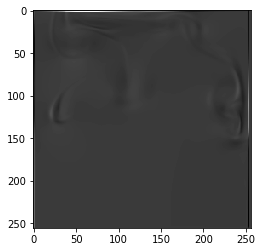

In [925]:
#!g1.1
vel = no_obs_val_dataset[797][1][None]
vdx = F.pad((vel[:, 1, :, 1:] - vel[:, 1, :, :-1])[:, None], (0, 1, 0, 0), mode='replicate')
udy = F.pad((vel[:, 0, 1:] - vel[:, 0, :-1])[:, None], (0, 0, 0, 1), mode='replicate')

w = vdx - udy
plt.imshow(w[0][0], cmap='gray')
             

In [905]:
#!g1.1

    if i == 20:
        break
    plt.imshow(den[0, 0])
    plt.show()

Error: Failed to run cell: internal error. Please try again